Missing values before handling: 1. open      0
2. high      0
3. low       0
4. close     0
5. volume    0
dtype: int64

Data Summary after Preprocessing:
Time range: 2024-07-01 04:00:00 to 2024-12-30 19:59:00
Total entries: 121379
Missing values: 2


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Epoch 1/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 203s 66ms/step - loss: 0.0035 - val_loss: 8.7468e-05
Epoch 2/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 199s 65ms/step - loss: 1.0691e-04 - val_loss: 5.6560e-05
Epoch 3/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 200s 64ms/step - loss: 2.1379e-05 - val_loss: 5.6255e-05
Epoch 4/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 194s 62ms/step - loss: 3.3138e-05 - val_loss: 5.6403e-05
Epoch 5/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 209s 64ms/step - loss: 2.5846e-05 - val_loss: 5.6210e-05
Epoch 6/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 202s 64ms/step - loss: 3.8966e-05 - val_loss: 5.6340e-05
Epoch 7/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 194s 61ms/step - loss: 2.8802e-05 - val_loss: 5.8241e-05
Epoch 8/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 202s 61ms/step - loss: 2.9246e-05 - val_loss: 5.6231e-05
Epoch 9/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 194s 64ms/step - loss: 2.7577e-05 - val_loss: 5.6096e-05
Epoch 10/20
3033/3033 ━━━━━━━━━━━━━━━━━━━━ 202s 64ms/step - loss: 2.4091e-05 - val_loss: 5.5221e-05
Epoch 11/20
3

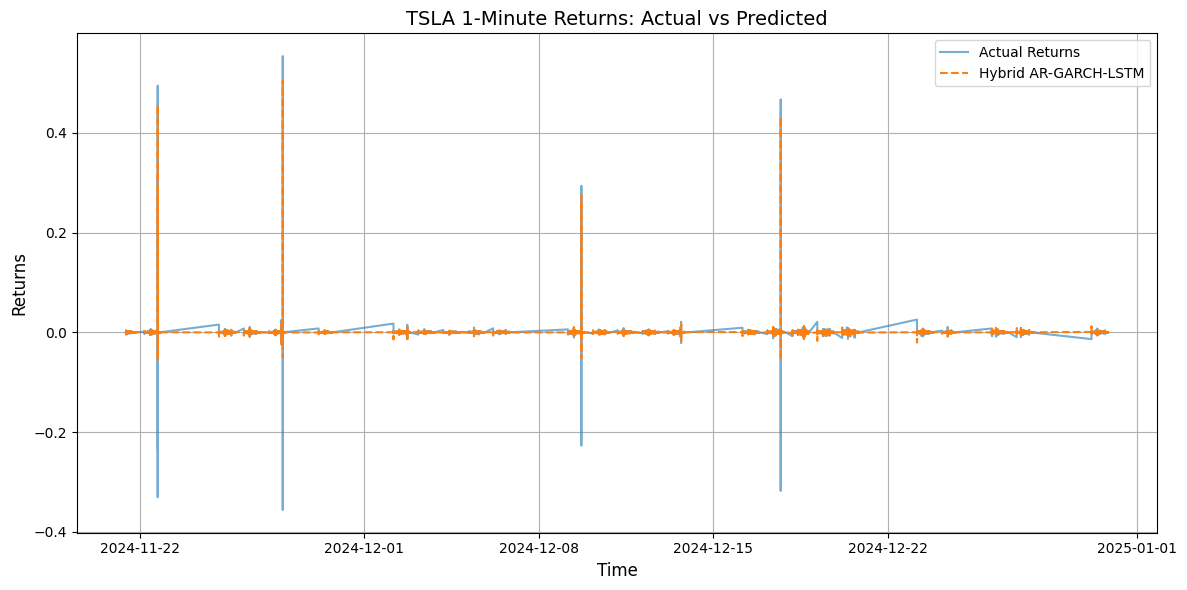

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# --- Data Preparation ---
def preprocess_data(file_path):
    # Load data with UTC timezone awareness
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date', dtype={'4. close': float})
    df.index = pd.to_datetime(df.index).tz_localize(None)  # Remove timezone if present

    # 1. Handle duplicates
    df = df[~df.index.duplicated(keep='last')]  # Keep last observation for duplicates

    # 2. Sort index if not monotonic
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()

    # 3. Handle missing values
    print(f"Missing values before handling: {df.isnull().sum()}")
    df['4. close'] = df['4. close'].ffill()  # Forward fill closing prices
    df = df.dropna()  # Drop any remaining rows with missing values

    # 4. Outlier detection and handling using Z-scores
    df['zscore'] = zscore(df['4. close'])
    df = df[(df['zscore'].abs() < 3)]  # Keep data within 3 standard deviations
    df = df.drop(columns=['zscore'])

    # 5. Add time-related features
    df['month'] = df.index.month

    # Calculate returns
    df['returns'] = df['4. close'].pct_change().dropna()
    df['volatility'] = df['returns'].abs()  # Simple volatility estimate

    return df

# Load and preprocess data
data = preprocess_data('TSLA_1min_data_24.csv')

# Verify preprocessing
print("\nData Summary after Preprocessing:")
print(f"Time range: {data.index.min()} to {data.index.max()}")
print(f"Total entries: {len(data)}")
print(f"Missing values: {data.isnull().sum().sum()}")

# Drop rows with NaN returns (from pct_change)
data = data.dropna()

# --- Step 1: Fit AR-GARCH Model ---
def fit_garch(returns):
    model = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='skewt')
    fitted_model = model.fit(disp='off')
    conditional_vol = fitted_model.conditional_volatility / 100  # Rescale
    residuals = returns - fitted_model.resid / 100
    return conditional_vol, residuals  # Corrected line

# Fit GARCH model on returns
garch_vol, garch_resid = fit_garch(data['returns'])

# --- Step 2: Prepare LSTM Inputs ---
def create_dataset(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Combine features: returns, GARCH volatility, GARCH residuals
features = np.column_stack([data['returns'], garch_vol, garch_resid])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Split into train/test (80/20)
train_size = int(len(scaled_features) * 0.8)
train, test = scaled_features[:train_size], scaled_features[train_size:]

# Create sequences
lookback = 60  # 60-minute window
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

# Reshape for LSTM: [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], lookback, 3)
X_test = X_test.reshape(X_test.shape[0], lookback, 3)

# --- Step 3: Build LSTM Model ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 3)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
history = model.fit(
    X_train, y_train[:, 0],  # Predict returns (column 0)
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test[:, 0]),
    verbose=1
)

# --- Step 4: Evaluate ---
def evaluate_model(X, y_true):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MSE: {mse:.6f}, MAE: {mae:.6f}")
    return y_pred

print("Train Metrics:")
train_pred = evaluate_model(X_train, y_train[:, 0])

print("\nTest Metrics:")
test_pred = evaluate_model(X_test, y_test[:, 0])

# Inverse scaling for actual values
test_pred_actual = scaler.inverse_transform(
    np.column_stack([test_pred, np.zeros((len(test_pred), 2))])
)[:, 0]
y_test_actual = scaler.inverse_transform(
    np.column_stack([y_test[:, 0], np.zeros((len(y_test), 2))])
)[:, 0]

# --- Step 5: Visualize Results ---
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+lookback:], y_test_actual, label='Actual Returns', alpha=0.6)
plt.plot(data.index[train_size+lookback:], test_pred_actual, label='Hybrid AR-GARCH-LSTM', linestyle='--')
plt.title('TSLA 1-Minute Returns: Actual vs Predicted', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('hybrid_garch_lstm_results.png', dpi=300)
plt.show()